<style>
    .latam-title {
            display: inline;
            padding: 20px;
        }
</style>
<div style="text-align: center;">
    <img src="https://download.logo.wine/logo/LATAM_Paraguay/LATAM_Paraguay-Logo.wine.png" alt="LATAM-LOGO" width="200" style="display: inline"/>      
    <h1 style="display: inline;">LATAM Challenge Development</h1>
</div>
<center>
<em>With love by Nicolás Zenteno Guardia</em>
</center>
<center>
<em>August 29th, 2023</em>
</center>
<p><em>Summary:-</em> This work shows the development of the LATAM Challenge sent to the candidates for the "Data Scientist" position. The problem to be solved consists in predicting the probability of delay of the flights that land or take off from the airport of Santiago de Chile
(SCL) using public and real data where each row corresponds to a flight that landed or took off
from SCL during 2017. For this we separe the problem in 5 parts</p>

<ol>
    <li> 
        <a href="#EDA">Exploratory Data Analysis:</a> How is the data distributed? Is there any noteworthy insight to share? What are the  conclusions?
    </li>
    <li> <a href="#DATA_PREP">Data Preparation:</a> Generation of aditional columns, new variables and others.</li>
    <li> <a href="#DELAY_RATE">Pre-Modelling Delay-Rate Understanding:</a> Understanding of the behavior of the delay rate across destination, airline, month of the year, day of the week, season and type of flight.</li>
    <li> <a href="#MODELLING">Modelling:</a> Train different models.</li>
    <li> <a href="#EVALUATION">Evaluation:</a> Evaluate the models.</li>
</ol>



<a id="EDA"><a>
<h1>1. Exploratory Data Analysis</h1>
    <h3>1.1 Import libraries and dataset</h3>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

# We get the raw content of the data in this github link.
file_url = "https://raw.githubusercontent.com/nizent/LATAMBestCompany/main/dataset_SCL.csv"

# As the flying numbers, and days, month and years are categorical or discrete numerical variables, we read them as strings not integers and dates as datetime64.
df = pd.read_csv(file_url, dtype={'Vlo-I':'str', 'Vlo-O':'str', 'DIA':'int', 'MES':'int', 'AÑO':'int'}, 
                 parse_dates=['Fecha-I', 'Fecha-O'])

# We assume that 400 and 400.0 are equals 
df["Vlo-I"]=df["Vlo-I"].str.replace('.0','', regex=False)
df["Vlo-O"]=df["Vlo-O"].str.replace('.0','', regex=False)

<h3>1.2 Understand data distribution</h3>

<em>Observations</em> 
<ul>
    <li>We have a total of 68.206 flights. All of them with city origin of Santiago.</li>
    <li>The most common day for flights is Friday, with 15% of flights scheduled in that day.</li>
    <li>The most common month for flights is December, with 9,3% of flights scheduled in that month.</li>
    <li>54% of flights are National and 46% International. </li>
    <li>The most common destination is Buenos Aires, with 9,3% of flights.</li>
    <li>The most common destination code is SCAF (Antofagasta), with 8,5% of flights. <br>
        This could be explained as Buenos Aires has more than one Airport (SAEZ, SABE and SEGU)</li>
    <li>The most common programmed and operating airline is LAN (55,1% and 30,8%).<br> This also means that there are reprogramations of flights with different airlines of the LATAM Group</li>
    <li>There is only one null value, and it is in the operating flight number.</li>
</ul>

In [2]:
description = df.describe(include=['O'])
NaN_count = df.isna().sum()

description.loc['na_count'] = NaN_count
description

,Vlo-I,Ori-I,Des-I,Emp-I,Vlo-O,Ori-O,Des-O,Emp-O,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
count,68206,68206,68206,68206,68205,68206,68206,68206,68206,68206,68206,68206,68206
unique,584,1,64,30,608,1,63,32,7,2,23,1,62
top,174,SCEL,SCFA,LAN,174,SCEL,SCFA,LAN,Viernes,N,Grupo LATAM,Santiago,Buenos Aires
freq,686,68206,5787,37611,686,68206,5786,20988,10292,36966,40892,68206,6335
na_count,0,0,0,0,1,0,0,0,0,0,0,0,0


<h3>1.2.1 Descriptive analysis by variable</h3>
<br>
As the columns are few, we will analyze each one in detail. The required matplotlib version is at least the 3.4.0 version to use bar_label function.

In [3]:
import matplotlib
print(matplotlib.__version__)

3.5.1


In [4]:
# We define a custom function to plot the categorical column distributions
def valueCountPlot(threshold = 0, column_name = "SIGLADES", figsize = (8,15), color = '#0f91f5', title='Title', ordered=0):
    value_counts_df = df[column_name].value_counts()
    filtered_value_counts = value_counts_df[value_counts_df > threshold]
    number_of_categories = len(filtered_value_counts)
    if ordered:
        filtered_value_counts = filtered_value_counts.sort_index()
        
    if number_of_categories == 1:
        print('There is only one category')
        print(filtered_value_counts)
        return 
    
    figsize = (8, int(number_of_categories/2))
    bars = filtered_value_counts.plot.barh(figsize=figsize, color=color, 
                                                   title=title)
    ax = plt.gca()
    bars.bar_label(bars.containers[0])
    ax.invert_yaxis()
    visible_spines = {'top': 0, 'left': 1, 'bottom': 0, 'right': 0}
    ax_customization = [ax.spines[key].set_visible(value) for key, value in visible_spines.items()]
    plt.show()
    return

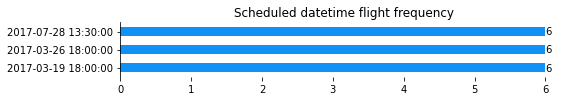

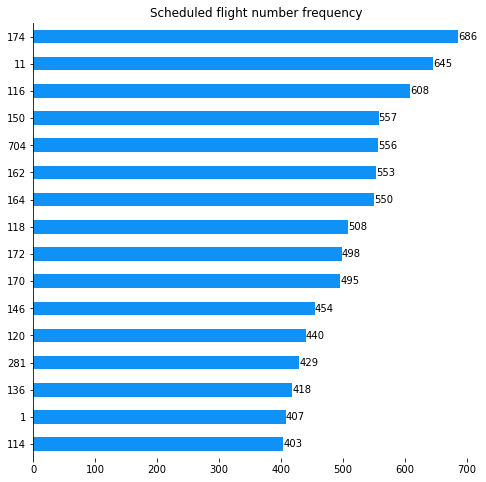

There is only one category
SCEL    68206
Name: Ori-I, dtype: int64


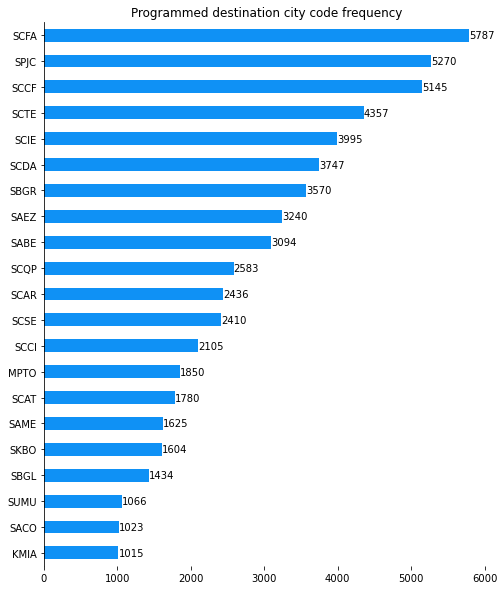

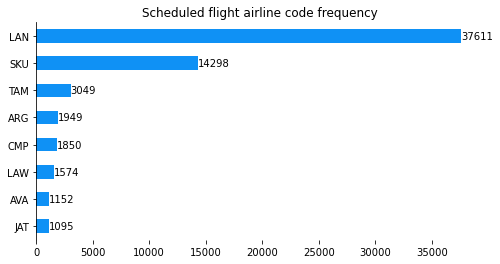

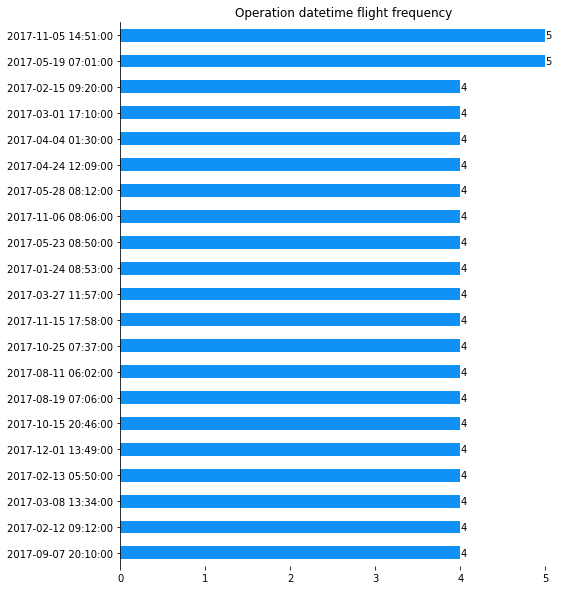

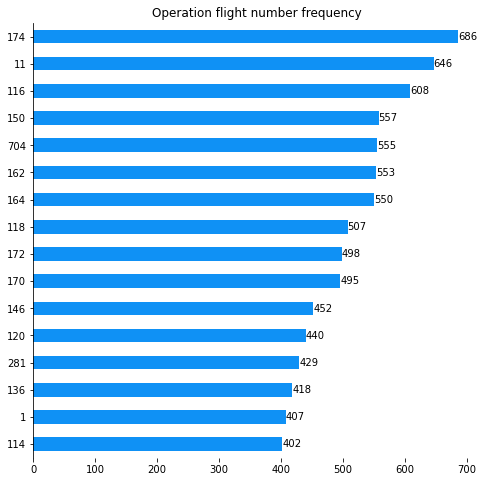

There is only one category
SCEL    68206
Name: Ori-O, dtype: int64


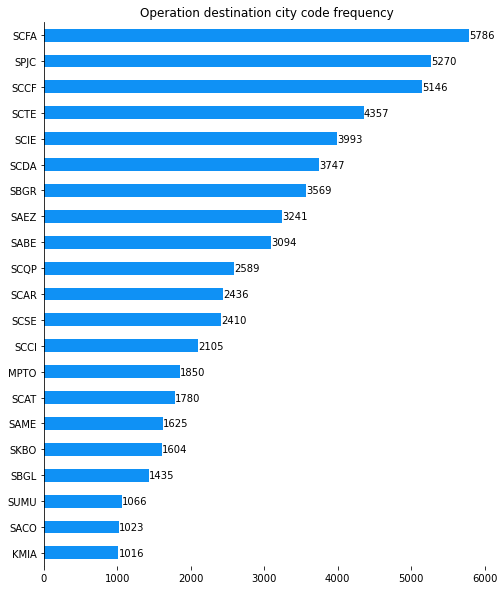

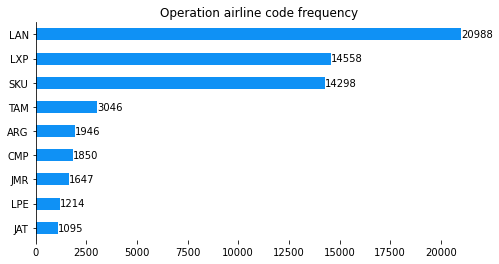

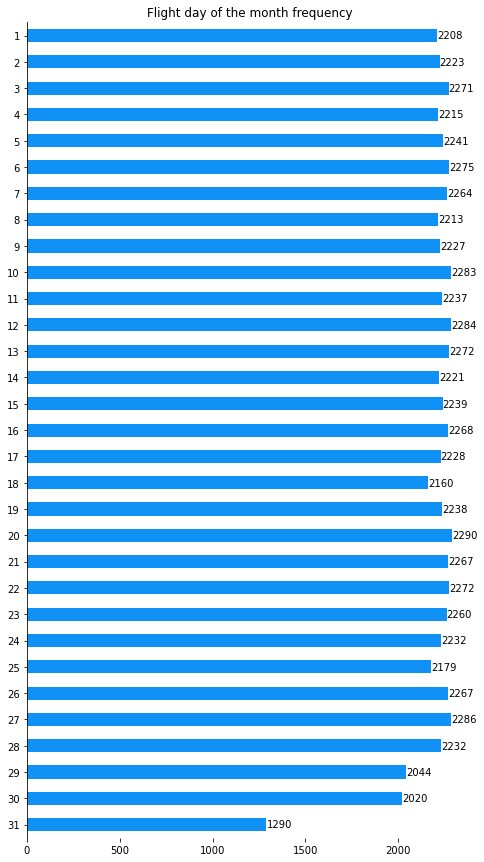

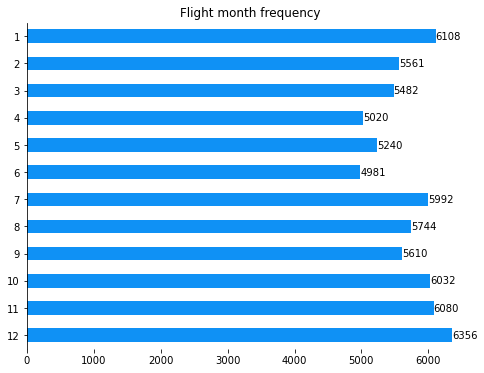

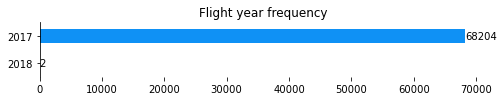

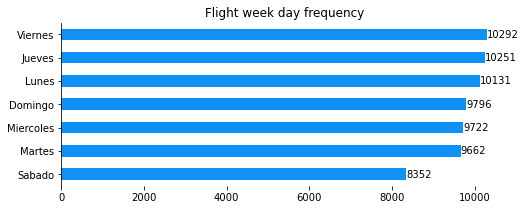

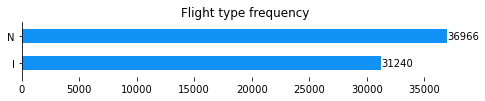

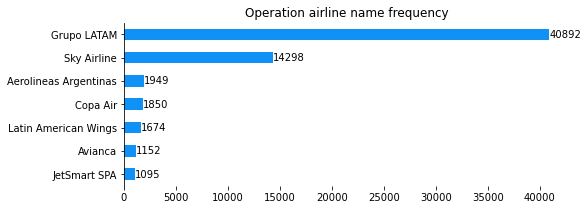

There is only one category
Santiago    68206
Name: SIGLAORI, dtype: int64


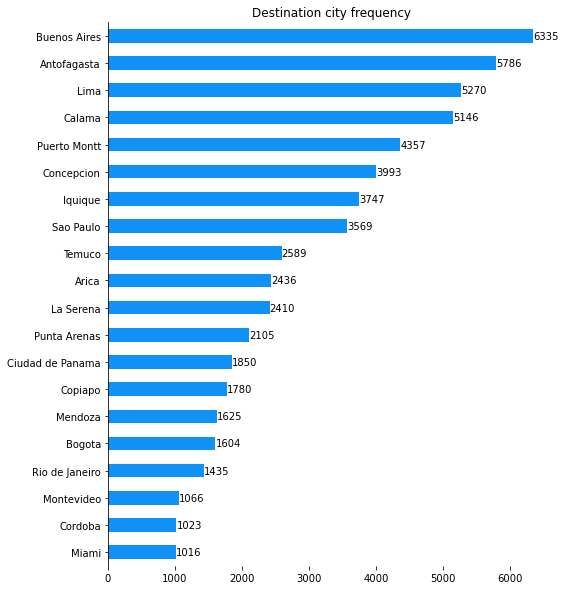

In [21]:
interpretable_column_name = {'Fecha-I': ['Scheduled datetime flight', 0], 'Vlo-I': ['Scheduled flight number', 0], 'Ori-I': ['Programmed origin city code', 0], 'Des-I': ['Programmed destination city code', 0], 'Emp-I': ['Scheduled flight airline code', 0], 'Fecha-O': ['Operation datetime flight', 0], 'Vlo-O': ['Operation flight number', 0], 'Ori-O': ['Operation origin city code', 0], 'Des-O': ['Operation destination city code', 0], 'Emp-O': ['Operation airline code', 0], 'DIA': ['Flight day of the month', 1], 'MES': ['Flight month', 1], 'AÑO': ['Flight year', 0], 'DIANOM': ['Flight week day', 0], 'TIPOVUELO': ['Flight type', 0], 'OPERA': ['Operation airline name', 0], 'SIGLAORI': ['City of origin', 0], 'SIGLADES': ['Destination city', 0]}
thresholds={'Fecha-I': 5, 'Vlo-I': 400, 'Ori-I': 1000, 'Des-I': 1000, 'Emp-I': 1000, 'Fecha-O': 3, 'Vlo-O': 400, 'Ori-O': 1000, 'Des-O': 1000, 'Emp-O': 1000, 'DIA': 0, 'MES': 0, 'AÑO': 0, 'DIANOM': 1000, 'TIPOVUELO': 1000, 'OPERA': 1000, 'SIGLAORI': 1000, 'SIGLADES': 1000}
comments={'Fecha-I': 'The maximum flights in a date and time is 6 flights.', 
          'Vlo-I': 'Most repeated flight numbers are #174, #11, #116', 'Ori-I': '', 
          'Des-I': 'SCFA, SPJC, SCCF are the most frequent scheduled destinations.', 
          'Emp-I': 'Most scheduled airlines are LAN and SKU.', 
          'Fecha-O': 'There are flights at the the same operation date times.', 
          'Vlo-O': 'The most frequent operation flight numbers are the same as the scheduled.', 'Ori-O': '',
          'Des-O': 'The same as scheduled.', 
          'Emp-O': 'The most frequent operation airlines are LAN, LXP and SKU.', 
          'DIA': 'The least frequent day of the month is 31, this could be explained as not all months have a 31 day. The majority of days have similar frequency.',
          'MES': 'The months with more frequency are January, December, November, October and July. All of them months where holidays are frequent or it is summer (except by July).', 
          'AÑO': 'There are two flights at 2018.', 
          'DIANOM': 'The days where are more flights are in Friday, Thursday and Monday. This could be due to take more advantage of the weekend, in the case of Friday and Thursday.', 
          'TIPOVUELO': 'There are more national flights.', 
          'OPERA': 'The operating airlines are in majority LATAM and SKY',
          'SIGLAORI': '', 'SIGLADES': 'Most frequent destinations are Buenos Aires, Antofagasta, Lima and Calama. As Chile is a Mining country, the mines are in the north, that could explain Antofagasta and Calama.'}
for column_name, params in interpretable_column_name.items():
    title, ordered = params[0], params[1] 
    display(HTML(f'<h3>{title}</h3>'))
    valueCountPlot(column_name = column_name, title=f'{title} frequency', threshold=thresholds[column_name], ordered=ordered)
    display(HTML(f'<p>{comments[column_name]}</p>'))

<h3>Q1: How is the data distributed? Is there any noteworthy insight to share? What are the  conclusions?</h3>
We can summarize the analysis in these points.
<ol>
    <li><b>DAY, MONTH and YEAR (numeric)</b>
        <p>The months with most frequency are January and December. That could be explained as these months are high season months which is preferred by Chileans to travel as they commonly take vacations in this season as the children don't go to school during that. The month with less flights is June, this month is at low season and could be explained with that. Another month that highlights is July, when scholars have winter holidays and it is frequent for travels with the family.</p><p>Also, the fact that in summer or high season the weather is better for flights, there is more probability of operational success in the flights. Otherwise, in winter in months as June, there are climatic conditions that can affect the operations of the airline.</p><p>The days of the months have an homogeneous distribution, except by the day 31 which only 7 months have it.</p><p>It is not recommendable to use the year as variable in thec model as it only have 2 values and mostly 2017, that would only inrease complexity, this applies for all columns that have only one value.</p><p></p>
    </li> 
    <li>
        <b>Categorical values</b>
        <p>The most frequent destinations are Buenos Aires, Antofagasta, Lima and Calama, representing 33% of flights. This could be explained as:</p><p>1. Chilean industry: Mining, Fishery, Cellulose among others industries that have their operations along Chile. Specially the mining sector where the operations are at different parts of the nort of Chile as Calama and Antofagasta (Antofagasta Minerals, Codelco, BHP, Anglo American) where their workers have to travel each week.</p>
        <p>2. Geographical proximity, culture and commerce: As Argentina, Perú are near to Chile and its native language is Spanish, it is a common destination for travelers, also, the proximity offers more affordable destinations for the people. In addition, these countries have a strong market relationship with Chile.</p>
        <p>The dataset is congruent with the fact that LATAM is the greatest airline in Latin America and is extended abroad Chile, offering a lot of options to travel along the country, with SKY, the second largest one in the country represents 80,9% of the flights.</p><p></p>
        <p><em>Technical observations:</em> Vlo-{I,O} have a lot of values as they are identifiers, it has no sense to put it in a model. And Ori-{I,O}, SIGLAORI have unique value, so adding those to a model would be useless.</p>
    </li>
</ol>

<a id="DATA_PREP"></a>
<h1>2. Data Preparation</h1>
<p>In this section of the work we will add some features to the dataset to understand in a better way the behavior of delay rates. For this we need to create new columns</p>
<ul>
    <li><u>high_season :</u> 1 if Date-I is between Dec-15 and Mar-3, or Jul-15 and Jul-31, or Sep-11 and Sep-30, 0 otherwise.</li>
    <li><u>min_diff :</u> difference in minutes between Date-O and Date-I .</li>
    <li><u>delay_15 :</u> 1 if min_diff > 15, 0 if not.</li>
    <li><u>period_day :</u> morning (between 5:00 and 11:59), afternoon (between 12:00 and 18:59) and night (between 19:00 and 4:59), based on Date-I .</li> 
</ul>

<h3>2.1 Creation of columns </h3>
We proceed to create the columns.

In [102]:
# As all the scheduled dates are for 2017, we can do this, if there would be more years we would use another way
high_season_bins = [df['Fecha-I'].min()]+[pd.to_datetime(f'2017-{date}') for date in ['03-03', '07-15', '07-31', '09-11', '09-30', '12-15']]+[pd.to_datetime('2018-01-01')]
high_season_labels = [1,0,1,0,1,0,1]
df['high_season'] = pd.cut(df['Fecha-I'], bins=high_season_bins, labels=high_season_labels, ordered=False, include_lowest=True).astype(int)

# We get the difference in minutes
df['min_diff'] = (df['Fecha-O']-df['Fecha-I']).dt.total_seconds()/60

# We classify the delay with a 15 minutes breakpoint
df['delay_15'] = (df['min_diff'] > 15).astype(int)

# We classify the hour of the day
period_day_bins = [0, 5, 12, 19, 24]
period_day_labels = ['night', 'morning', 'afternoon', 'night']
df['period_day'] = pd.cut(df['Fecha-I'].dt.hour, bins=period_day_bins, labels=period_day_labels, ordered=False, include_lowest=True)

<h3>2.2 Creation of dataset </h3>
We export them to a CSV file named synthetic_features.csv

In [6]:
df[['high_season', 'min_diff', 'delay_15', 'period_day']].to_csv('synthetic_features.csv')

<h3>2.3 Additional features </h3>
We create these variables that we think could be relevant
<ol>
    <li><u>airline_changed:</u> This could be sign of operational efficiency taking advantage of leasing and commercial relations with other airlines (assumption).</li>
    <li><u>hour:</u> It could aggragate more insights about the behavior of period of day.</li>
    <li><u>airport_congestion:</u> The number of flights that are being realized in each our in the airport.</li>
</ol>

In [202]:
df['airline_changed'] = (df['Emp-I']!=df['Emp-O']).astype(int)
df['hour'] = (df['Fecha-I']).dt.hour
df['airport_congestion'] = df.groupby(pd.Grouper(key='Fecha-I', freq='H'))['Fecha-I'].transform('size')

<a id='DELAY_RATE'></a><h1>3. Understanding Delay Rate</h1><br>
In this section we will analyze the recently created variable behavior against different features.

<h3>3.1 How is delay distributed? What is the maximum and minimum difference in minutes?</h3>

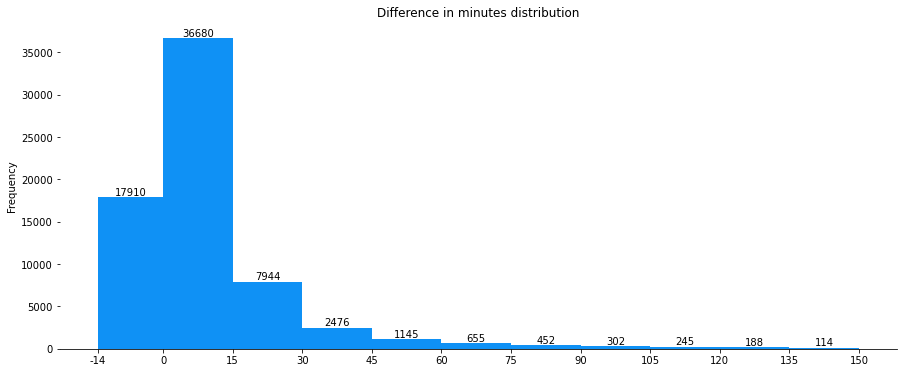

In [8]:
# First we visualize the min_diff distribution with a histogram
nbins = int(df.min_diff.max()/15)
bins = [int(df.min_diff.min())]+[15*i for i in range(0, nbins+1)]
label_bins = [f'[{bins[i]}-{bins[i+1]})' for i in range(0, nbins+1)]
bars = df['min_diff'].plot.hist(color = '#0f91f5', bins=bins, figsize=(15,6), title = "Difference in minutes distribution")
plt.xticks(bins,bins)
plt.bar_label(bars.containers[0])
ax=plt.gca()
visible_spines = {'top': 0, 'left': 0, 'bottom': 1, 'right': 0}
ax_customization = [ax.spines[key].set_visible(value) for key, value in visible_spines.items()]

<b>Observations</b>
<ol>
    <li>80% of flights have less than 15 minutes of difference between scheduled and operation date.</li>
    <li>The maximum delay is of 150 minutes</li>
    <li>The minimum difference is -14 minutes</li>
</ol>

<h3>3.2 Delay rate behavior</h3>
In this part we analyze each variable and its average delay rate.  

In [22]:
def plotTarget(df = df, column_name = 'SIGLADES', target_column = 'delay_15', color = '#0f91f5', threshold = 0, title = 'Title'):
    agg_info = df[[column_name, target_column]].groupby(column_name)[target_column].agg(['mean', 'count'])
    agg_info = agg_info[agg_info['count'] > threshold]
    figsize=(max(len(agg_info)/2, 5), max(len(agg_info)/5, 5))
    delay_rate_mean = df[target_column].mean()
    bars = agg_info['mean'].plot.bar(figsize=figsize, color=color, label=f'Mean of {column_name}', title = title, ylabel=target_column)
    ax = plt.gca()
    value_counts = agg_info['count']
    for bar, value_count in zip(ax.patches, value_counts):
        height = bar.get_height()
        ax.annotate(f'{value_count}', (bar.get_x() + bar.get_width() / 2, height), ha='center', va='bottom')
    
    plt.axhline(y = delay_rate_mean, color = 'r', linestyle = '--', label=f'Delay rate mean: {delay_rate_mean:.2f}')
    plt.legend(loc='lower right')
    visible_spines = {'top': 0, 'left': 0, 'bottom': 1, 'right': 0}
    ax_customization = [ax.spines[key].set_visible(value) for key, value in visible_spines.items()]
    plt.show()
    return

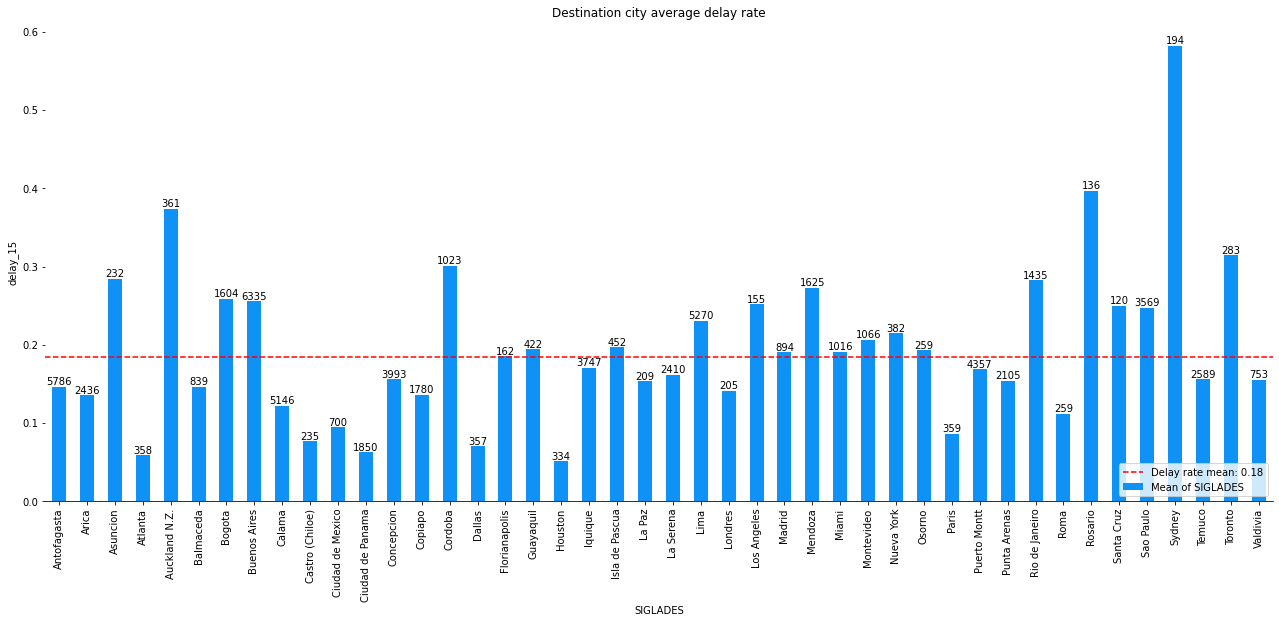

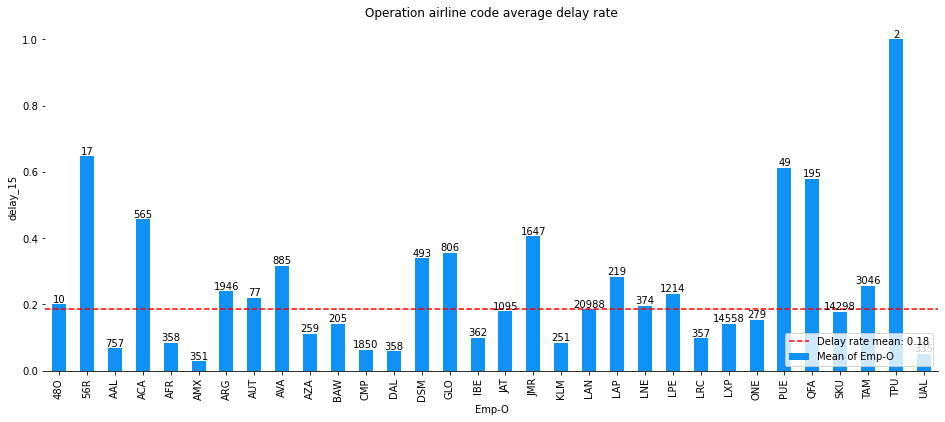

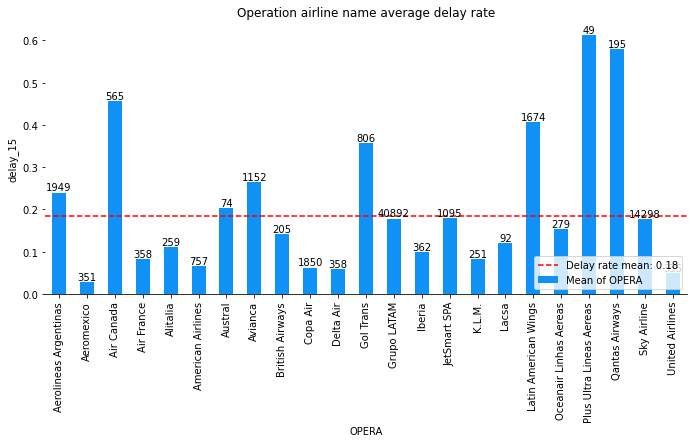

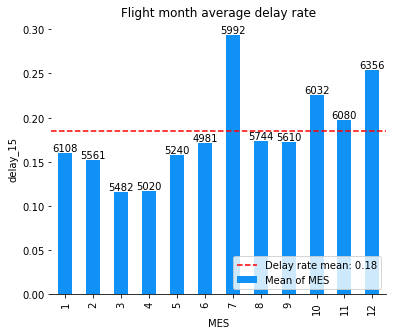

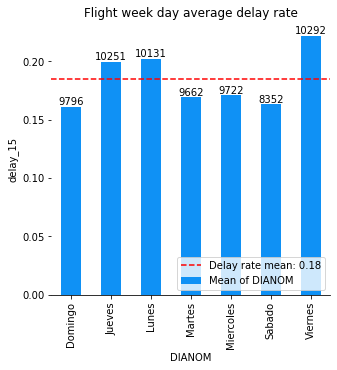

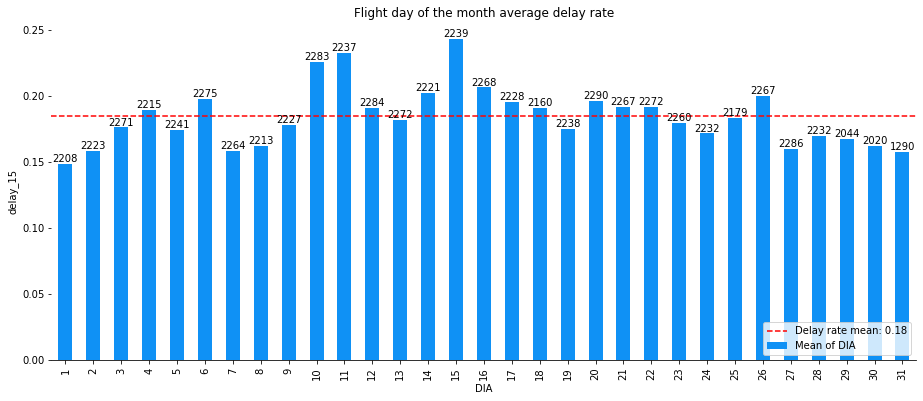

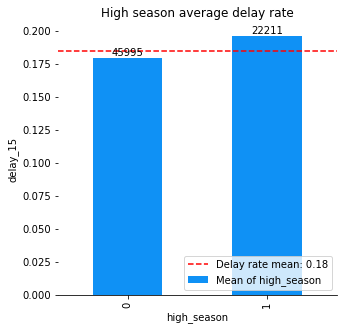

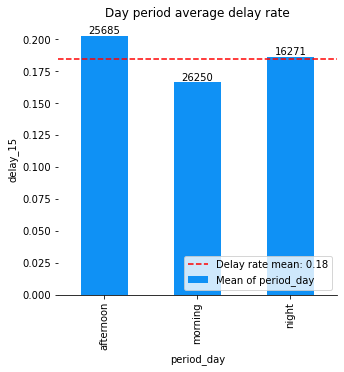

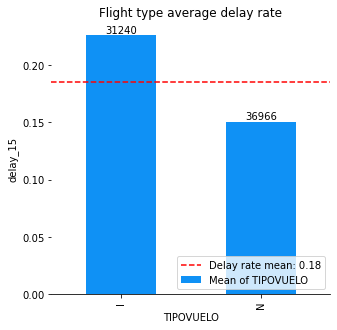

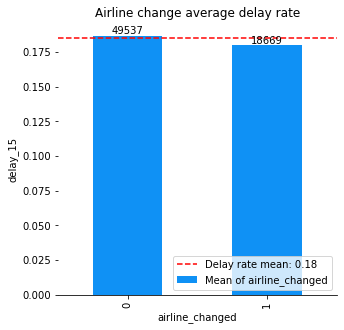

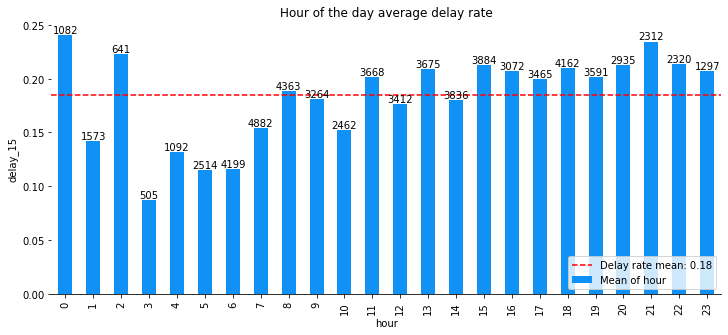

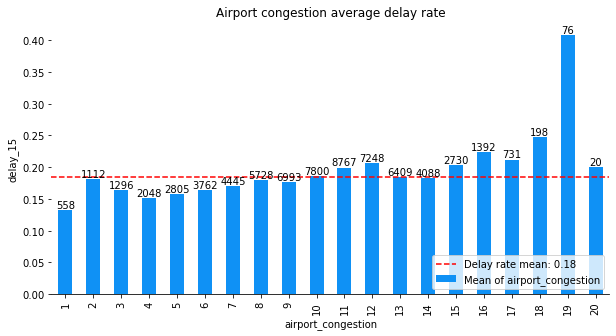

In [204]:
column_params={
    'SIGLADES': [100, 'Sydney and Auckland are the countries with more than 100 travels with the highest delay rate. On the contrary, Houston, Atlanta and Paris have the lowest rate.'],
    'Emp-O': [0, 'TAM has a higher delay rate than LAN. The ones with more than 100 samples and highest delay rates are QFA, ACA and JMR, in opposite than AMX, UAL and DAL.'],
    'OPERA': [0, 'LATAM Group and SKY Airline have a delay rate lower than the average. The ones with highest rates are Plus Ultra Lineas Aereas, Qantas Airways, Air Canada and Latin American Wings.'],
    'MES': [0, 'The months that have a rate higher than the average are July, October, November and December, most of them in high seasons.'],
    'DIANOM': [0, 'Friday, Thursday and Monday are the days with higher rates. Probably due to congestion traffic near to weekends and holidays.'],
    'DIA': [0, 'The day with highest rate is 15th. The highest rated occur in the second and third week of the month.'],
    'high_season': [0, 'In high season delays are higher.'], 
    'period_day': [0, 'In mornings delay rates are lower. Contrary to afternoon, where delay rates are higher.'],
    'TIPOVUELO': [0, 'International flights are significant more delayed than national flights. This could be due to the distance of flights.'],
    'airline_changed': [0, 'There is no much difference.'],
    'hour': [0, 'While later, higher delay rates.'],
    'airport_congestion': [0, 'While higher congestion, higher delay rates.'],
}

interpretable_column_name['high_season']=['High season',]
interpretable_column_name['period_day']=['Day period',]
interpretable_column_name['airline_changed']=['Airline change',]
interpretable_column_name['hour']=['Hour of the day',]
interpretable_column_name['airport_congestion']=['Airport congestion',]

for column_name, params in column_params.items():
    name=interpretable_column_name[column_name][0]
    display(HTML(f'<h3>{name}</h3>'))
    plotTarget(column_name=column_name, threshold=params[0], title=f'{name} average delay rate')
    display(HTML(f'{params[1]}'))

<h3>Q3: What is the behavior of the delay rate across destination, airline, month of the year, day of the week, season, type of flight? What variables would you expect to have the most influence in predicting delays?</h3>

The most relevant variables at this exploratory analysis are
<ol>
    <li>Type of flight: The difference is considerable, the international flights have more delay than national ones. This could be associated with distance and climatic conditions. </li>
    <li>The day period: In mornings the delay rates are lower. This could be explained with the fact that in the morning the levels of congestions are lower (contrary to afternoon), so there are less delays.</li>
    <li>Month: In July the delays rates are higher, this is probably due to the climatic conditions of the country (winter) that could affect the operation. Also in December, where there is more traffic as it is the begining of the high season. In the contrary, we have March and April, with the lowest rates, as they have less demand (low season).</li>
    <li>Week day: Days near to weekends have higher delay rates. As these days represent days of high demand.</li>
    <li>The destination: There are flights that take too much time and distance as Sydney and Auckland that are at the opposite hemisphere from Chile. They have delay rates higher than 0.35. Also, as the distance is larger, there are climatic conditions, congestion in the airports that could affect the flight.</li>
    <li>The airline: This could be related to internal operational factors that are inefficient inside the companies or the destinations that they offer could be of larger distances. So, we have the higher rates in Plus Ultra Lineas Aereas, Qantas Airways, Air Canada and Latin American Wings, and lower rates in Aeromexico, United Airlines and American Airlines. As LATAM is a group of airlines, it has a rate near to the global average. </li>
    <li>Airport congestion: While more flights in the airport, more delay.</li>
</ol>

Among these variables, the ones that are most important, in my opinion, are type of flight, weekday, airline, month, air congestion and destination.

<a id='MODELLING'></a>
<h1>4. Modelling</h1>
As the data has only 68.206 rows (lower than 100K samples), we prefer using the following recommended models
<ol>
    <li><u>Logistic Regression:</u> Commonly used for predicting the probability of success of an event.</li>
<li><u>Random Forest Classifier:</u> Used for classification, it is a decision Tree based on the bootstrap technique or bagging.</li>
    <li><u>K-Nearest Neighbors Classifier:</u> Used for classification, it uses proximity to classify the data.</li>
    <li><u>Extreme Gradient Boosting:</u> Used for classification, it uses multiple weak learners to ensemble them and give a better response by reducing their bias.</li>
</ol> 

<h3>4.1 Importing libraries and preparing data</h3>
Here we import encoders, scalers, models that we could use to model the delay rate. We will not use each one due to time, but we will test the most standards models.

In [137]:
# Models
from sklearn.linear_model import SGDClassifier, LogisticRegression
from xgboost import plot_importance, XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV

# Preprocessing, training and evaluation
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, mean_absolute_error, mean_absolute_error,mean_squared_error, r2_score, balanced_accuracy_score

# To balance data
import imblearn

import warnings
warnings.filterwarnings('ignore')

# To measure time
import time

In [122]:
# Models to test, described above!
models = {
    'Logistic Regression': LogisticRegression(), 
    'Random Forest': RandomForestClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'XGBoost': XGBClassifier(),
}

# It is proven that scaling data could improve model performance
scalers = {
    'MinMax': MinMaxScaler(),
    'Standard': StandardScaler(),
}

<h3>4.2 Variable selection</h3>
As we defined previously, we will use the following columns for the models, each one with its scaler, encoder to improve performance.

In [205]:
# For binary variables there is no need of scaling (high_season)
numeric_columns = {
    'MES': 'MinMax',
    'hour': 'MinMax',
    'airport_congestion': 'MinMax',
    'high_season': None,
}

# For categorical variables that don't have any order, we prefer using one-hot-encoder. For columns that have order, we use 
# label encoder (day, period_day, )
categorical_columns = {
    'TIPOVUELO': 'OneHot', 
    'Emp-O': 'OneHot',
    'DIANOM': 'Label',
    'period_day': 'Label',
    'SIGLADES': 'OneHot',
}

<h3>4.3 Metrics selection</h3>
We will show the following metrics to compare each model.

In [206]:
# This function return the metrics that we will use for measuring the model performance
def get_metrics(y_pred=[], y_test=[], probs=[]):
    return {
        'balanced_accuracy': balanced_accuracy_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'mae': mean_absolute_error(y_test, probs),
        'rmse': mean_squared_error(y_test, probs)**0.5,
        'r2': r2_score(y_test, probs)
    }

<h3>4.4 Preparing training and test datasets</h3>
We will use a 20% of the data for testing.

In [207]:
target_column = ['delay_15']
numeric_column_names =  list(numeric_columns.keys())
categorical_column_names = list(categorical_columns.keys())
selected_columns = numeric_column_names + categorical_column_names + target_column
one_hot_columns = [key for key, values in categorical_columns.items() if value == 'OneHot']
label_columns = [key for key, values in categorical_columns.items() if value == 'Label']

X = df[selected_columns].drop('delay_15', axis=1)
X = pd.get_dummies(X, columns = one_hot_columns)

label_encoder = LabelEncoder()
for column in label_columns:
    X[column] = label_encoder.fit_transform(X[column])

# Scale data

for column in numeric_column_names: 
    if numeric_columns[column]:
        scaler = scalers[numeric_columns[column]]
        X[column] = scaler.fit_transform(X[[column]])
        
y = df['delay_15']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

<h3>4.5 Training and evaluating the models</h3>
We test time execution of the trainings and get metrics.

In [208]:
def train_models(X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test, models = models):
    reports_test = []
    for model_name, model in models.items():
        start = time.time()
        model.fit(X_train, y_train)
        start = time.time()
        print(f"{model_name}: {round(time.time()-start)} seconds.\n")

        # For test data
        y_pred = model.predict(X_test)
        probs = model.predict_proba(X_test)[:, 1]
        report_test = get_metrics(y_test=y_test, y_pred=y_pred, probs=probs)
        reports_test.append(report_test)
    
    return reports_test

report_test = train_models()

Logistic Regression: 0 seconds.

Random Forest: 0 seconds.

K-Nearest Neighbors: 0 seconds.

XGBoost: 0 seconds.



In [209]:
def showMetrics(reports_test = reports_test, models = models):
    return pd.DataFrame(reports_test, index=models.keys())

showMetrics()

,balanced_accuracy,recall,precision,f1,mae,rmse,r2
Logistic Regression,0.518755,0.043511,0.635359,0.081445,0.285306,0.381905,0.066282
Random Forest,0.567056,0.227393,0.369392,0.281499,0.266035,0.422325,-0.141824
K-Nearest Neighbors,0.555129,0.167991,0.411492,0.238581,0.268509,0.405262,-0.051421
XGBoost,0.551522,0.120318,0.625984,0.201841,0.269894,0.373521,0.106825


<b>Best performance</b> goes from XGBoost model, with a RMSE of 0.37, and LogisticRegression with a RMSE of 0.38. The recall is low, so there could be problems predicting the dataset.

<h3>4.7 Dealing with imbalance</h3>
One way to deal with imbalance is oversampling.

In [210]:
display(HTML(f'There is only {y.sum()} delays over {len(y)} samples') )

In [211]:
over_sampling = imblearn.over_sampling.RandomOverSampler(random_state=10)
X_train_os, y_train_os = over_sampling.fit_resample(X_train, y_train)

os_models = {
    'LogisticRegression': LogisticRegression(),
    'XGBoost': XGBClassifier()
}

report_test_os = train_models(X_train=X_train_os, y_train=y_train_os, models=os_models)

LogisticRegression: 0 seconds.

XGBoost: 0 seconds.



In [212]:
showMetrics(reports_test=report_test_os, models=os_models)

,balanced_accuracy,recall,precision,f1,mae,rmse,r2
LogisticRegression,0.632090,0.612940,0.296921,0.400049,0.451440,0.473645,-0.436191
XGBoost,0.646766,0.600832,0.319646,0.417291,0.407644,0.450867,-0.301378


<b>Best performance</b> goes from XGBoost, with lower MAE and RMSE and the highest F1 score. Also both models have better recall from the previous training section.

<h3>4.7 Hyperparameters optimization.</h3>
Here we will execute a gridearch with predefined parameters. As today is the limit date for ending this challenge we will test only the XGBoost model in this gridsearch.

In [213]:
last_models = {
    'XGBClassifier': XGBClassifier(),
}

gridsearch = {
    'XGBClassifier': {
        'gamma': [0.5, 1],
        'max_depth': [4, 6] 
    }
}

xgb_str='XGBClassifier'

gs = GridSearchCV(last_models[xgb_str], param_grid = gridsearch[xgb_str], verbose=4)

last_optimus_model = gs.fit(X_train_os, y_train_os)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END ............gamma=0.5, max_depth=4;, score=0.681 total time=   6.0s
[CV 2/5] END ............gamma=0.5, max_depth=4;, score=0.673 total time=   6.1s
[CV 3/5] END ............gamma=0.5, max_depth=4;, score=0.678 total time=   6.6s
[CV 4/5] END ............gamma=0.5, max_depth=4;, score=0.678 total time=   6.9s
[CV 5/5] END ............gamma=0.5, max_depth=4;, score=0.666 total time=   7.1s
[CV 1/5] END ............gamma=0.5, max_depth=6;, score=0.706 total time=   9.8s
[CV 2/5] END ............gamma=0.5, max_depth=6;, score=0.705 total time=   9.7s
[CV 3/5] END ............gamma=0.5, max_depth=6;, score=0.711 total time=  10.1s
[CV 4/5] END ............gamma=0.5, max_depth=6;, score=0.705 total time=  10.2s
[CV 5/5] END ............gamma=0.5, max_depth=6;, score=0.703 total time=  10.2s
[CV 1/5] END ..............gamma=1, max_depth=4;, score=0.677 total time=   7.1s
[CV 2/5] END ..............gamma=1, max_depth=4;,

In [214]:
best_params = gs.best_params_
best_estimator = gs.best_estimator_
best_score = gs.best_score_

print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)

Best Parameters: {'gamma': 0.5, 'max_depth': 6}
Best Cross-Validation Score: 0.7060188831223394


The best params are gamma value of 0.5 and max depth of 6. We will use these to evaluate the model

<h3>4.8 Feature importance</h3>
Finally, we check the feature importance.

In [218]:
best_params = {
    'gamma': 0.5,
    'max_depth': 6
}

final_models = {
    'XGBoost' : XGBClassifier(**best_params),
}

report_final_test = train_models(X_train=X_train_os, y_train=y_train_os, models=final_models)

XGBoost: 0 seconds.



In [219]:
showMetrics(reports_test=report_final_test, models=final_models)

,balanced_accuracy,recall,precision,f1,mae,rmse,r2
XGBoost,0.648933,0.600076,0.323014,0.419966,0.407581,0.450591,-0.29978


The metrics are slightly better than the previous model, acheiving a balanced accuracy of almost 65% and a f1 of 42%.

<a id='EVALUATION'></a>
<h1>5. Evaluation and conclusions </h1>
<h3>Q5: Evaluate model performance in the predictive task across each model that you trained. Define and justify what metrics you used
to assess model performance. Pick the best trained model and evaluate the following: What variables were the most influential in
the prediction task? How could you improve the performance?.</h3>

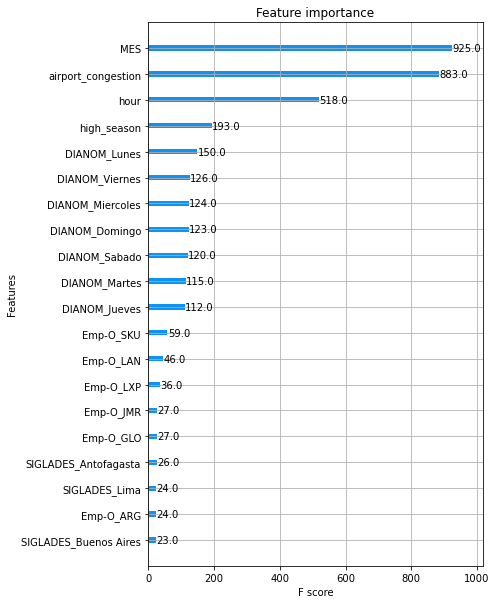

In [220]:
fig, ax = plt.subplots(figsize=(6,10))
plot_xgb = plot_importance(os_models['XGBoost'], max_num_features=20, color='#0f91f5', ax=ax)
plt.show()

The most important variables are
<ol>
    <li>Month/high season:As we saw in the previous sections months of higher demand or higher season have more probability of having flights with delay, this due to the high congestion in air traffic.</li>
    <li>Airport congestion: The more flights, the more delay rates.</li>
    <li>Hour: The hour of the day matters because of the fact that in morning airlines have better operations and less congestion.</li>
</ol>

<h3>5.1 How to improve performance?</h3>
There are different ways of improving this model. Adding variables as
<ol>
    <li>Information of the previous flight: It is common for airlines that delays occur because the last flight had a delay, so the flight has to wait the previous flight.</li>
    <li>Country distance: When the countries are far, there is more probability of delay. This could make a more exact model.</li>
    <li>Internal ratings of efficiency: One of the most common causes of delays are the internal operational issues that can delay a flight. This could be added into a variable with the rating of an airline. This also could be added with the NPS of the airlines (customer satisfaction).</li>
    <li>Climatic conditions by geography: This is important because all flights depends on climatic conditions.</li>
    <li>Security info: There are security warnings that can affect a lot of flights, things like bombs, accidents, pandemics or other things.</li>
    <li>Airport capacity: How many flights by hour an airport can perform. This is important and can trigger more delays.</li>
    
In a technical way, there are options too:
    <li>Neural networks or deep learning algorithms: They can lead to a better performance but they are a black box, they are not interpretable like the models we tested here.</li>
    <li>A deeper optimization of parameters, or more modesl to be tested: Only because of time we didn't test models ike linear SVC, SGD, GaussianNB, KMeans and others... </li>
    
</ol>